# Create a stochastic block model graph and compare to super Mapper across all sessions

In [17]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
from utils import *

sessions = load_scrubbed(n_sessions=-1, merge=True,
                         apply_tmask=True,apply_rmask=True,
                         rmask_kwds=dict(n=12,minor=False),zscore=False)

splits = get_data_splits(sessions,zscore=True,groupby='day_of_week',groups={2: 'fast', 4: 'fed'})

bestres = 20
bestgain = 8.
overlap = (bestgain - 1) / bestgain

X_fed = splits.fed.X
X_fast = splits.fast.X

majorRSNs = ['Cingulo_opercular','Frontoparietal_1','Somatomotor','Visual_2','DMN',
             'Dorsal_Attention', 'Ventral_Attention', 'Salience', 'Visual_1', 'Medial_Parietal',
             'Parieto_occipital', 'Frontoparietal 2']

majorRSNs = np.sort(majorRSNs)

roi2rsn = np.array(sessions.atlas['data']['network'])
roi2rsn_clean = roi2rsn[np.isin(roi2rsn,majorRSNs)]

df_roi_rsn = pd.DataFrame(0,index=np.arange(roi2rsn_clean.shape[0]),columns=majorRSNs)
for ind,roi in enumerate(roi2rsn_clean):
    df_roi_rsn.loc[ind,roi] = 1

INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': True, 'apply_tmask': True, 'apply_rmask': True, 'rmask_kwds': {'n': 12, 'minor': False}, 'zscore': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 0, file: sub014.txt
INFO:root:      keeping: 505 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 1, file: sub015.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 2, file: sub016.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 3, file: sub017.txt
INFO:root:      keeping: 504 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 4, file: sub018.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 5, file: sub019.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 6, file: sub020.

INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 63, file: sub082.txt
INFO:root:      keeping: 502 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 64, file: sub083.txt
INFO:root:      keeping: 482 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 65, file: sub084.txt
INFO:root:      keeping: 515 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 66, file: sub085.txt
INFO:root:      keeping: 518 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 67, file: sub086.txt
INFO:root:      keeping: 515 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 68, file: sub087.txt
INFO:root:      keeping: 516 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 69, file: sub088.txt
INFO:root:      keeping: 516 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 70, file: sub089.txt
INFO:root:      kee

            0.0 => day_of_week_0    x.shape: (510, 554)  RSN.shape: (510, 12)
            1.0 => day_of_week_1    x.shape: (5893, 554)  RSN.shape: (5893, 12)
            2.0 => fast             x.shape: (20262, 554)  RSN.shape: (20262, 12)
            4.0 => fed              x.shape: (15576, 554)  RSN.shape: (15576, 12)


### Run Mapper across all sessions

In [2]:
# Run Mapper/DyNeuSR
results_fed = run_mapper(X_fed.T,df_roi_rsn,verbose=1,cover=km.Cover(bestres,overlap))
# Visualize DyNeuGraph
results_fed['dG'].visualize(path_html='results/fed_super_spatial_all.html', show=False, reset=True, static=False, PORT=8800)
# Run Mapper/DyNeuSR
results_fast = run_mapper(X_fast.T,df_roi_rsn,verbose=1,cover=km.Cover(bestres,overlap))
# Visualize DyNeuGraph
results_fast['dG'].visualize(path_html='results/fast_super_spatial_all.html', show=False, reset=True, static=False, PORT=8800)

dGfed = results_fed['dG']
dGfast = results_fast['dG']

KeplerMapper()
Mapping on data shaped (554, 15576) using lens shaped (554, 2)

Creating 400 hypercubes.

Created 385 edges and 183 nodes in 0:00:01.776984.


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed_super_spatial_all.html
KeplerMapper()
Mapping on data shaped (554, 20262) using lens shaped (554, 2)

Creating 400 hypercubes.

Created 372 edges and 186 nodes in 0:00:02.078381.


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fast_super_spatial_all.html


### Estimate probabilities of edges between communities

We estimate this by calculating the number of edges between a node in community A and any node in community B, then dividing by the total number of possible edges (which is essentially the number of nodes in community B), and average across all nodes in community A to get the probability of an edge existing between A and B. This can be achieved by taking the ROI x ROI matrix, summing the values in the region that connects A to B (ignore B to A), and divide this sum by number of nodes in B * number of nodes in A. If community A and B are the same, then make sure to divide this sum by two first.

In [3]:
def rsn_index_change(sorted_rsns):
    """
    Process sorted array of network labels, return an array of indexes where the label changes
    """
    index_array = []
    current_label = 'batman'
    for ind,label in enumerate(sorted_rsns):
        if label != current_label:
            current_label = label
            index_array.append(ind)
    # Add ending index
    index_array.append(len(sorted_rsns) - 1)
    return index_array

In [32]:
from matplotlib import patches

def add_rsn_patches(ax, lenx, leny, boundaries, color_array, alpha_param = 1.0, offset = 1.0):
    """
    Plots rectangular patches vertically and horizontally for each network bounded by the indices
    provided using the colors provided
    """
    # Loop through boundaries
    for num,ind in enumerate(boundaries[:-1]):
        nextind = boundaries[num+1]
        hrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
        ax.add_patch(hrect)
        vrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
        ax.add_patch(vrect)

In [33]:
from matplotlib import cm

def plot_network_adj(A):
    
    rsnidx = np.argsort(roi2rsn_clean)
    rect_inds = rsn_index_change(roi2rsn_clean[rsnidx])

    plt.close('all')
    plt.imshow(A,cmap='binary_r')
    ax = plt.gca()
    cmap = cm.get_cmap('tab20', 20)
    colors = cmap(np.linspace(0,1,20))

    add_rsn_patches(ax,A.shape[1],A.shape[0],rect_inds,colors[:len(majorRSNs)],alpha_param=1.0,offset=2)

    plt.show()

In [39]:
import collections

def createSBM(TCM, num_itera=30):
    """
    Take an ROI x ROI matrix from a DyNeuSR and create a similar SBM
    """
    # Get sorting indices based on ROI -> RSN mapping
    rsnidx = np.argsort(roi2rsn_clean)
    # Sort ROI x ROI matrix in both dimensions
    A = TCM[rsnidx,:]
    A = A[:,rsnidx]
    # Get number of nodes in each community
    nodecount = collections.Counter(roi2rsn_clean[rsnidx])
    sizes = [nodecount[key] for key in sorted(nodecount.keys())]
    # Get the indices of the bounds between RSN regions in the matrix
    bounds = rsn_index_change(roi2rsn_clean[rsnidx])
    # Create array to hold probabilities
    probs = np.zeros((len(majorRSNs),len(majorRSNs)))
    # Go through bounds twice, once for each dimension
    for comm1,b1 in enumerate(bounds[:-1]):
        for comm2,b2 in enumerate(bounds[:-1]):
            # End index of the region in matrix that belongs to this RSN
            nextb1 = bounds[comm1+1]
            nextb2 = bounds[comm2+1]
            # Sum the values in this region
            num_edges = np.sum(A[b1:nextb1,b2:nextb2])
            # Divide by 2 if same community
            if comm1 == comm2:
                num_edges /= 2
            # Divide by number of nodes in community 1 * nodes in community 2
            p = num_edges / float(sizes[comm1] * sizes[comm2])
            # Add to appropriate locations in probs
            probs[comm1,comm2] = p

    # Run SBM
    Anull = [nx.to_numpy_array(nx.stochastic_block_model(sizes,probs)) for i in range(num_itera)]
    Anull_mean = np.mean(Anull,axis=0)
    
    plot_network_adj(Anull_mean)

### Run SBM

<IPython.core.display.Javascript object>


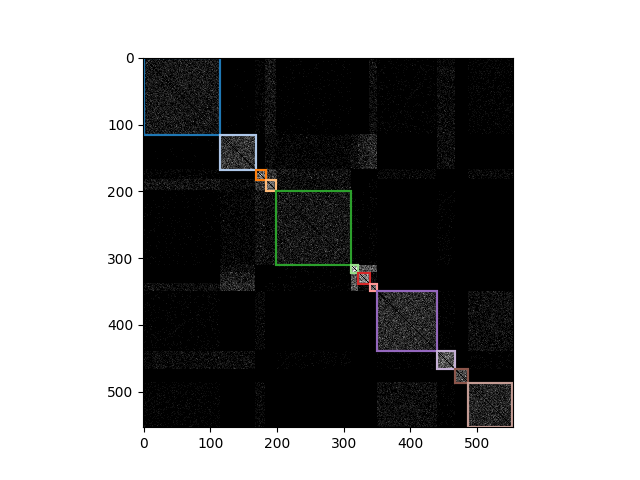

In [40]:
createSBM(dGfed.tcm_, num_itera=30)

<IPython.core.display.Javascript object>


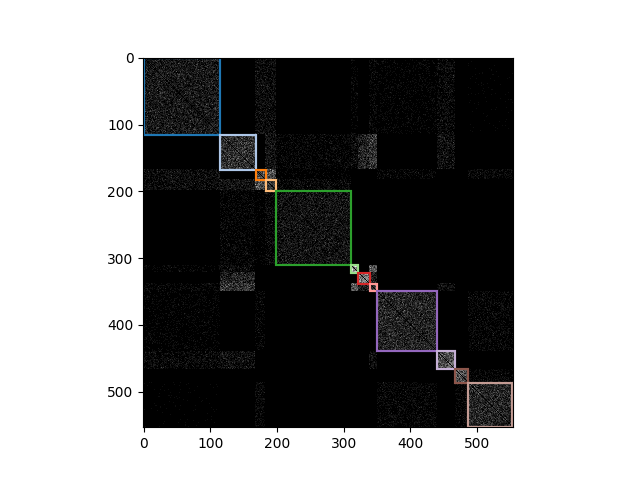

In [41]:
createSBM(dGfast.tcm_, num_itera=30)